In [1]:
!pip install xgboost


Defaulting to user installation because normal site-packages is not writeable


# Block 1: Data Loading and Preprocessing

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns

# Load the data
file = r"C:\Users\JUNAID HABIB\OneDrive - Higher Education Commission\Desktop\Pichala\AIM\Dataset\phases.xlsx"
data = pd.read_excel(file)

# Drop unnecessary columns
if "Alloy" in data.columns:
    data = data.drop(columns=["Alloy"])

# Separate features (X) and target (y)
X = data.drop(columns=["H/M"])
y = data["H/M"]

# Define categorical and numerical features
categorical_features = ["Predicted_Phase"] if "Predicted_Phase" in X.columns else []
numerical_features = ["H_mix", "S_mix", "Atomic", "Del_en", "VEC"]

# Add polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X[numerical_features])
X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(numerical_features))

# Combine with original categorical features
X_combined = pd.concat([X_poly, X[categorical_features].reset_index(drop=True)], axis=1)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),  # Scale numerical features
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),  # Encode categorical features
    ],
    remainder="passthrough"  # Keep other columns if any exist
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Block 2: Model Training and Evaluation

Mean Absolute Error (MAE): 0.0956
Mean Squared Error (MSE): 0.0127
R² Score: 0.2027


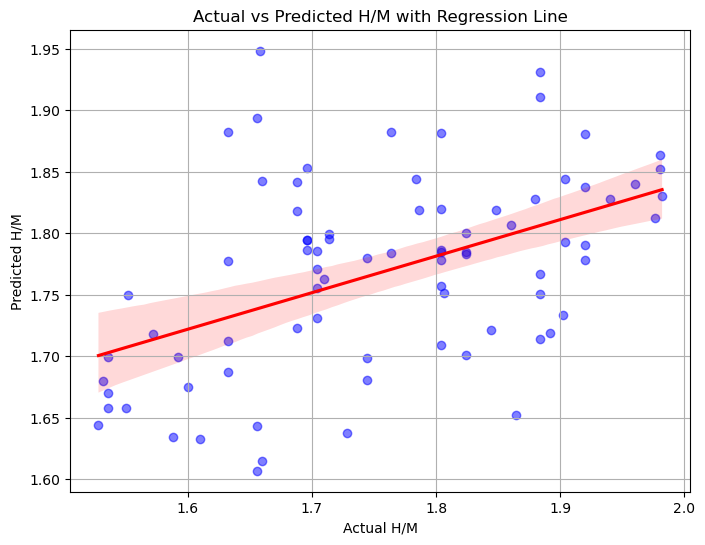

C:\Users\JUNAID HABIB\AppData\Local\Temp\ipykernel_12760\2316798646.py:39: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, color="purple", shade=True)


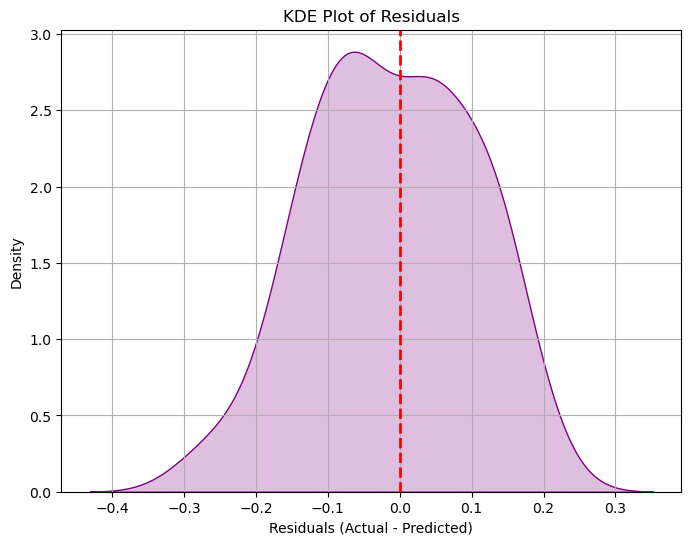

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Create the XGBoost model
model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)

# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# Scatter plot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={"alpha": 0.5, "color": "blue"}, line_kws={"color": "red"})
plt.xlabel("Actual H/M")
plt.ylabel("Predicted H/M")
plt.title("Actual vs Predicted H/M with Regression Line")
plt.grid(True)
plt.show()

# Residual KDE plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.kdeplot(residuals, color="purple", shade=True)
plt.axvline(0, color="red", linestyle="--", linewidth=2)
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Density")
plt.title("KDE Plot of Residuals")
plt.grid(True)
plt.show()


# Block 3: Hyperparameter Tuning and Feature Importance

In [ ]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold

# Define the parameter grid
param_grid = {
    "model__n_estimators": [50, 100, 200, 300],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "model__max_depth": [3, 5, 7, 9],
    "model__subsample": [0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.8, 0.9, 1.0],
    "model__gamma": [0, 0.1, 0.2],
}

# Use Repeated K-Fold for cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Best Model MAE: {mae_best:.4f}")
print(f"Best Model R²: {r2_best:.4f}")

# Feature importance plot
feature_importance = best_model.named_steps["model"].feature_importances_
feature_names = numerical_features + list(best_model.named_steps["preprocessor"]
                                          .named_transformers_["cat"]
                                          .get_feature_names_out(categorical_features))

# Sort features by importance
sorted_indices = np.argsort(feature_importance)

plt.figure(figsize=(10, 8))
plt.barh(np.array(feature_names)[sorted_indices], feature_importance[sorted_indices], color="teal")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in XGBoost Model")
plt.grid(True)
plt.show()

Fitting 15 folds for each of 1728 candidates, totalling 25920 fits


In [ ]:
import joblib

# Save the model
joblib.dump(best_model, "best_model.pkl")

# Load the model (for future use)
# loaded_model = joblib.load("best_model.pkl")